# Выпускной проект - телеком
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
# Описание услуг
Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.
# Описание данных
Данные состоят из файлов, полученных из разных источников:
- contract.csv — информация о договоре;
- personal.csv — персональные данные клиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.  

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020.


# Критерий оценки
ROC_AUC < 0.75 - неудовлетворительно  
0.75 <= ROC_AUC < 0.85 - удовлетворительно  
0.85 <= ROC_AUC < 0.88 - хорошо  
0.88 <= ROC_AUC - отлично

## Импорт библиотек

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
# sns.set_theme()

import plotly.express as px

from tqdm.notebook import tqdm_notebook as tq_n

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold

from sklearn.feature_selection import RFECV

from sklearn.preprocessing import OrdinalEncoder
OE = OrdinalEncoder()

In [4]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [5]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

In [6]:
SCORING='roc_auc'
RANDOM_STATE = 250722

## Открытие файлов

In [7]:
try:
    df_contract = pd.read_csv('contract.csv')
    df_personal = pd.read_csv('personal.csv')
    df_internet = pd.read_csv('internet.csv')
    df_phone = pd.read_csv('phone.csv')
except:
    pass

### Изучение файлов

#### Договоры

In [8]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [9]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


#### Клиенты

In [10]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [11]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


#### Интернет услуги

In [12]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


#### Телефония

In [14]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [15]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


## Предобработка данных

### Контракты

В таблице `контракты`, отсутсвует целевой признак.  Введем его. т.к. наша задача - это задача бинарной классификации(уйдет клиент или останется), то создадим столбец, в котром `1` - значает, что клиент уйдет, а `0` - останется.  
Так же введем новый признак: сколько времени пользователь является клиентом компании.

In [16]:
# столбец is_left
df_contract['is_left'] = df_contract['EndDate'].apply(lambda x: 0 if x=='No' else 1)

# даты с No заменим на актуальные
df_contract.loc[df_contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

# изменим тип данных в столбцах со временем
df_contract[['BeginDate', 'EndDate']] = df_contract[['BeginDate', 'EndDate']].apply(pd.to_datetime)

# новый признак
df_contract['time_use'] = (df_contract['EndDate'] - df_contract['BeginDate']).apply(lambda x: x.days)

In [17]:
# проверка
df_contract['is_left'].value_counts()

0    5174
1    1869
Name: is_left, dtype: int64

Изменим тип столбца `TotalCharges`

In [18]:
try:
    df_contract['TotalCharges'] = df_contract['TotalCharges'].apply(pd.to_numeric)
except:
    print('ошибка')

ошибка


Проверим, из-за чего возникает ошибка, при изменении типа данных в столбце `TotalCharges`

In [19]:
df_contract['TotalCharges'].value_counts().sort_values(ascending=False)

           11
20.2       11
19.75       9
20.05       8
19.9        8
           ..
3886.45     1
1224.05     1
2310.2      1
723.4       1
6844.5      1
Name: TotalCharges, Length: 6531, dtype: int64

В столбце присутствует пустые значения `' '`. Рассмотрим их

In [20]:
df_contract[df_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_left,time_use
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,0


11 позиций с пустым значением в столбце `TotalCharges`. Эти пользователи заключили контракт в последнюю дату нашего датасета. Удалим их, т.к. они не несут смысловой нагрузки.

In [21]:
df_contract = df_contract.loc[df_contract['TotalCharges'] != ' ']

In [22]:
try:
    df_contract['TotalCharges'] = df_contract['TotalCharges'].apply(pd.to_numeric)
except:
    print('ошибка')

Поменяем местами столбцы. Это нужно для лучшего ориентира в столбцах.

In [23]:
df_contract = df_contract.reindex(columns=[
    'customerID',
    'BeginDate', 'EndDate', # Замена
    'MonthlyCharges',
    'TotalCharges',
    'time_use',
    'is_left',
    'Type',
    'PaperlessBilling',
    'PaymentMethod'
])

In [24]:
df_contract.head()

,customerID,BeginDate,EndDate,MonthlyCharges,TotalCharges,time_use,is_left,Type,PaperlessBilling,PaymentMethod
0,7590-VHVEG,2020-01-01,2020-02-01,29.85,29.85,31,0,Month-to-month,Yes,Electronic check
1,5575-GNVDE,2017-04-01,2020-02-01,56.95,1889.50,1036,0,One year,No,Mailed check
2,3668-QPYBK,2019-10-01,2019-12-01,53.85,108.15,61,1,Month-to-month,Yes,Mailed check
3,7795-CFOCW,2016-05-01,2020-02-01,42.30,1840.75,1371,0,One year,No,Bank transfer (automatic)
4,9237-HQITU,2019-09-01,2019-11-01,70.70,151.65,61,1,Month-to-month,Yes,Electronic check


In [25]:
df_contract.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
MonthlyCharges             float64
TotalCharges               float64
time_use                     int64
is_left                      int64
Type                        object
PaperlessBilling            object
PaymentMethod               object
dtype: object

### Клиенты

Изменим значения в столбце `SeniorCitizen` на `Yes` и `No`

In [26]:
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].apply(lambda x: 'Yes' if x==1 else 'No')
df_personal['SeniorCitizen'].unique()

array(['No', 'Yes'], dtype=object)

## Анализ

Рассмотрим распределения ежемесячных поступлений от ушедших и оставшихся клиентов.

,Остались,Ушли
mean,61.31,74.44
std,31.09,24.67
min,18.25,18.85
25%,25.10,56.15
50%,64.45,79.65
75%,88.48,94.20
max,118.75,118.35


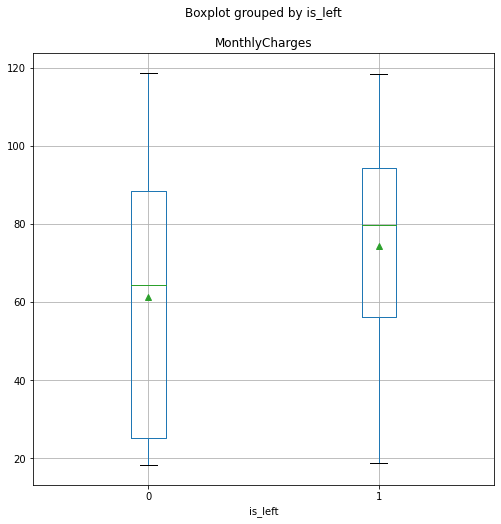

In [27]:
df_contract.boxplot(
    'MonthlyCharges',
    by='is_left',
    figsize=(8,8),
    showmeans=True
)

pd.concat(
    [df_contract[df_contract['is_left']==0]['MonthlyCharges'].describe().round(2),
    df_contract[df_contract['is_left']==1]['MonthlyCharges'].describe().round(2)], axis=1
    ).set_axis(['Остались', 'Ушли'], axis=1).iloc[1:]

Клиенты, разорвавшие контракт, в среднем, производили больше ежемесячных поступлений.

Введем еще два признака:
- клиент пользуется интернетом
- клиент пользуется телефонной связью

In [28]:
df_contract['is_phone'] = df_contract['customerID'].isin(
    df_phone['customerID']).apply(lambda x: 0 if x == False else 1)

df_contract['is_internet'] = df_contract['customerID'].isin(
    df_internet['customerID']).apply(lambda x: 0 if x == False else 1)

Создадим два датафрейма с данными ушедших и оставшихся клиентов.

In [29]:
df_is_left = df_contract[df_contract['is_left'] == 0]
df_is_stay = df_contract[df_contract['is_left'] == 1]

Рассмотрим гистограммы ежемесяных платежей.

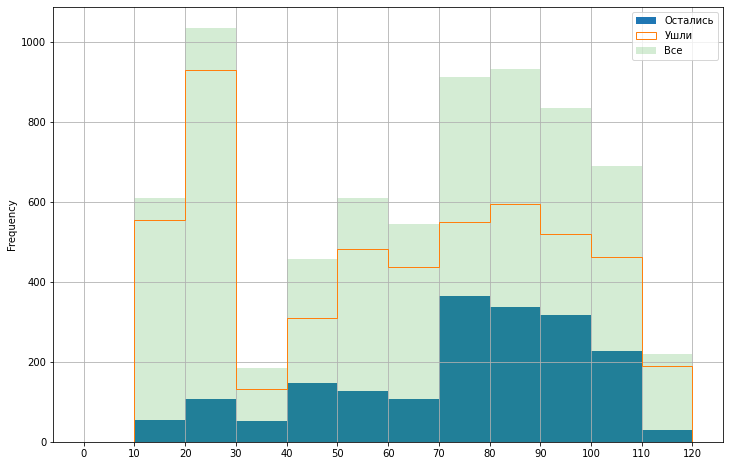

In [30]:
bins = np.arange(0,130, 10)

ax = df_is_stay.plot(
    kind='hist',
    bins=bins,
    y='MonthlyCharges',
    label='Остались',
    figsize=(12,8),

    xticks=bins
)

df_is_left.plot(
    kind='hist',
    bins=bins,
    y='MonthlyCharges',
    histtype='step',
    label='Ушли',
    ax=ax,

)

df_contract.plot(
    kind='hist',
    bins=bins,
    y='MonthlyCharges',
    alpha=0.2,
    label='Все',
    ax=ax,
    grid=True,
);

Рассмотрим, сколько клиентов пользуются телефонной связью

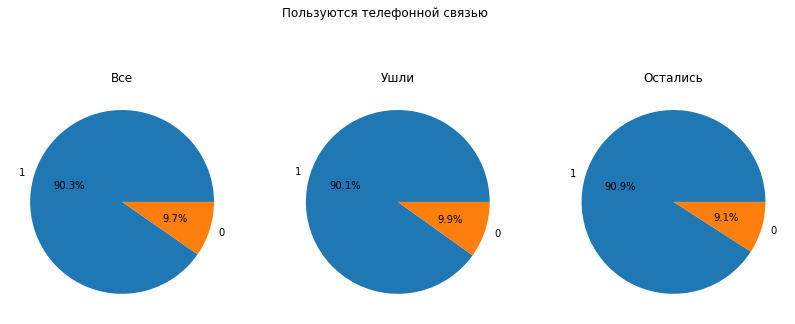

In [31]:
# Настройка цветовой гаммы
# colors = sns.color_palette('pastel')[0:5]
# sns.color_palette("coolwarm", as_cmap=True)

col_name='is_phone'
labels = ['Да', 'Нет']

plt.figure(    figsize=(14,10))

plt.suptitle('Пользуются телефонной связью')
# =====================================================
plt.subplot(2, 3, 1)

data = df_contract[col_name].value_counts()

ax = data.plot(kind='pie', autopct='%1.1f%%', title='Все', ylabel='')
# =====================================================
plt.subplot(2, 3, 2)

data = df_is_left[col_name].value_counts()

data.plot(kind='pie', autopct='%1.1f%%', title='Ушли', ylabel='')
# =====================================================
plt.subplot(2, 3, 3)

data = df_is_stay[col_name].value_counts()

data.plot(kind='pie', autopct='%1.1f%%', title='Остались', label='')

plt.show();

Доля клиентов одинакова у всех категорий клиентов.

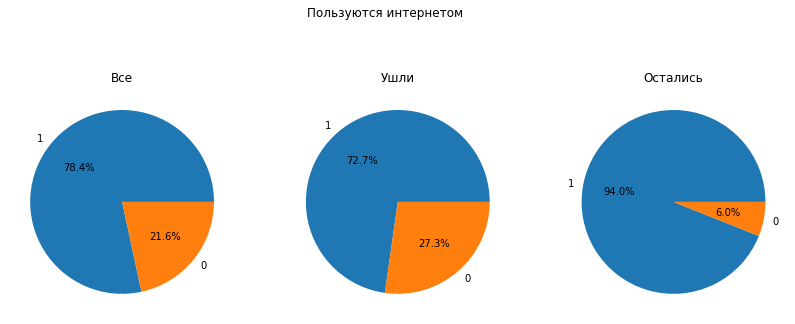

In [32]:
# Настройка цветовой гаммы
# colors = sns.color_palette('pastel')[0:5]
# sns.color_palette("coolwarm", as_cmap=True)

col_name='is_internet'
labels = ['Да', 'Нет']

plt.figure(    figsize=(14,10))

plt.suptitle('Пользуются интернетом')
# =====================================================
plt.subplot(2, 3, 1)

data = df_contract[col_name].value_counts()

ax = data.plot(kind='pie', autopct='%1.1f%%', title='Все', ylabel='')
# =====================================================
plt.subplot(2, 3, 2)

data = df_is_left[col_name].value_counts()

data.plot(kind='pie', autopct='%1.1f%%', title='Ушли', ylabel='')
# =====================================================
plt.subplot(2, 3, 3)

data = df_is_stay[col_name].value_counts()

data.plot(kind='pie', autopct='%1.1f%%', title='Остались', label='')

plt.show();

Количество ушедших клиентов, использующие интернет, меньше количества оставшихся клиентов.

In [33]:
# удалим столбцы с датами
df_contract.drop(['BeginDate', 'EndDate'], axis=1, inplace=True)

## Объединение таблиц

При объединеии таблиц учтем, что существует клиенты, которые используют либо интернет либо телефонную связь. Заменим пропуски на `No`

In [34]:
df_final = (
    df_contract
    .merge(df_personal, how='left', on='customerID')
    .merge(df_internet, how='left', on='customerID')
    .merge(df_phone, how='left', on='customerID')
)

# используем id клиентов в качестве индексов датафрейма
df_final.set_index('customerID', inplace=True)

# заменим пропуски на 'No'
df_final.loc[df_final['InternetService'].isna(), df_internet.columns[1:]] = 'No'

df_final.loc[df_final['MultipleLines'].isna(), 'MultipleLines'] = 'No'

# проверка
print(df_final.isna().sum().sum())

df_final.head()

0


,MonthlyCharges,TotalCharges,time_use,is_left,Type,PaperlessBilling,PaymentMethod,is_phone,is_internet,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,29.85,31,0,Month-to-month,Yes,Electronic check,0,1,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,56.95,1889.50,1036,0,One year,No,Mailed check,1,1,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,53.85,108.15,61,1,Month-to-month,Yes,Mailed check,1,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,42.30,1840.75,1371,0,One year,No,Bank transfer (automatic),0,1,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,70.70,151.65,61,1,Month-to-month,Yes,Electronic check,1,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


Используем ОНЕ-кодирование категориальных переменных. Приведем все значения к типу `int`

In [35]:
df_final = pd.get_dummies(df_final, drop_first=True).astype('int')

In [36]:
df_final

,MonthlyCharges,TotalCharges,time_use,is_left,is_phone,is_internet,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29,29,31,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,56,1889,1036,0,1,1,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,53,108,61,1,1,1,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,42,1840,1371,0,0,1,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
9237-HQITU,70,151,61,1,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,84,1990,730,0,1,1,1,0,1,0,...,1,0,0,1,0,1,1,1,1,1
2234-XADUH,103,7362,2191,0,1,1,1,0,1,1,...,1,1,0,0,1,1,0,1,1,1
4801-JZAZL,29,346,337,0,0,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0


In [37]:
df_final.dtypes

MonthlyCharges                           int32
TotalCharges                             int32
time_use                                 int32
is_left                                  int32
is_phone                                 int32
is_internet                              int32
Type_One year                            int32
Type_Two year                            int32
PaperlessBilling_Yes                     int32
PaymentMethod_Credit card (automatic)    int32
PaymentMethod_Electronic check           int32
PaymentMethod_Mailed check               int32
gender_Male                              int32
SeniorCitizen_Yes                        int32
Partner_Yes                              int32
Dependents_Yes                           int32
InternetService_Fiber optic              int32
InternetService_No                       int32
OnlineSecurity_Yes                       int32
OnlineBackup_Yes                         int32
DeviceProtection_Yes                     int32
TechSupport_Y

Создадим датасеты признаков

In [38]:
X = df_final.drop('is_left', axis=1)
y= df_final['is_left']

In [39]:
df_final.to_csv('dataset.csv', index=False)

## Обучение

Обучим модели с помощью жадного алгоритма и метода отбора значимости признаков через кросс-валидацию.  
Плюсы жадного алгоритма:
- высокие значения искомых метрик
минусы:
- используется только под конкретную модель,
- долгое время работы  

В качестве модели будем использовать модель CatBoostClassifier

### Жадный алгоритм для CatBoost

<font color='red'>**Комментарий:**</font> для экономии времени во время отладки, части кода выведены в ячейки MarkDown. Результаты работы алгоритмов вынесены в отдельные датафреймы.

Создадим необходимые выборки

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y, # стратифицированные выборки
    random_state=RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5274, 24) (5274,)
(1758, 24) (1758,)


Стратифицированные фолды с повторениями. Повторения позволяют увеличить точность градиентного бустинга

In [41]:
CV = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)

```
# жадный алгоритм
model_cat = CatBoostClassifier(
        random_seed=RANDOM_STATE,
        verbose=1000,
        eval_metric='AUC'
    )

a_dict = dict()
itog_dict = dict()
while len(X_train.columns) >=2:
    a_dict = dict()
    
    for i in tq_n(X_train.columns):
        a_dict[i] = cross_val_score(
        model_cat, X_train.drop(i,axis=1), y_train,
        scoring=SCORING, cv=CV, n_jobs=-1).mean()
        
    X_train = X_train.drop(max(a_dict, key=a_dict.get), axis=1)
    itog_dict [ max(a_dict, key=a_dict.get) ] = max(a_dict.values())
    print(itog_dict)
```

Итог работы алгоритма

In [42]:
greedy_col = [
    'TotalCharges', 'MonthlyCharges', 'Partner_Yes', 'StreamingTV_Yes',
    'SeniorCitizen_Yes', 'PaymentMethod_Electronic check', 'PaymentMethod_Credit card (automatic)',
    'MultipleLines_Yes', 'DeviceProtection_Yes', 'OnlineSecurity_Yes',
    'Dependents_Yes', 'OnlineBackup_Yes', 'gender_Male', 'PaperlessBilling_Yes',
    'TechSupport_Yes', 'PaymentMethod_Mailed check', 'StreamingMovies_Yes',
    'is_phone', 'is_internet', 'Type_One year', 'Type_Two year', 'InternetService_No', 'InternetService_Fiber optic'
]

greedy_roc_auc = [
    0.901733371644682, 0.910477058679599, 0.912724627725309, 0.913327113365148,
    0.914214957993014, 0.91558437914109, 0.917761449801528, 0.918678995757243,
    0.919576305839296, 0.920255902737123, 0.920619504326386, 0.92108655702097,
    0.922484556177597, 0.923210404896385, 0.924744553251937, 0.925309426515669,
    0.925905288003283, 0.925872752931284, 0.925834027225031, 0.925562781042235,
    0.923002428356623, 0.917656517404219, 0.908064026416916
]
df_score = pd.DataFrame(data=greedy_col, columns=['del_col'])
df_score['auc_roc'] = greedy_roc_auc
df_score

,del_col,auc_roc
0,TotalCharges,0.901733
1,MonthlyCharges,0.910477
2,Partner_Yes,0.912725
3,StreamingTV_Yes,0.913327
4,SeniorCitizen_Yes,0.914215
5,PaymentMethod_Electronic check,0.915584
6,PaymentMethod_Credit card (automatic),0.917761
7,MultipleLines_Yes,0.918679
8,DeviceProtection_Yes,0.919576
9,OnlineSecurity_Yes,0.920256


Найдем значения метрик accuracy, f1_score, precision и recall для тестовой выборки, удаляя столбцы, последовательность которых является результатом работы жадного алгоритма

In [43]:
scores_acc = []
scores_f1 = []
scores_prec = []
scores_rec = []

for i in tq_n(greedy_col):
    X_train = X_train.drop(i, axis=1)
    
    model_cat = CatBoostClassifier(
        random_seed=RANDOM_STATE,
        verbose=1000,
        eval_metric='AUC'
    )
    model_cat.fit(X_train, y_train),
    predict = model_cat.predict(X_test)
    
    scores_acc.append(
        accuracy_score(y_test, predict)
    )
    
    scores_f1.append(
        f1_score(y_test, predict)
    )     
    
    scores_prec.append(
        precision_score(y_test, predict)
    )
    
    scores_rec.append(
        recall_score(y_test, predict)
    )

  0%|          | 0/23 [00:00<?, ?it/s]

Learning rate set to 0.020955
0:	total: 140ms	remaining: 2m 19s
999:	total: 6.55s	remaining: 0us
Learning rate set to 0.020955
0:	total: 3.48ms	remaining: 3.47s
999:	total: 7.36s	remaining: 0us
Learning rate set to 0.020955
0:	total: 14.2ms	remaining: 14.2s
999:	total: 7.73s	remaining: 0us
Learning rate set to 0.020955
0:	total: 12.5ms	remaining: 12.5s
999:	total: 7.42s	remaining: 0us
Learning rate set to 0.020955
0:	total: 19.7ms	remaining: 19.7s
999:	total: 7.75s	remaining: 0us
Learning rate set to 0.020955
0:	total: 3.54ms	remaining: 3.54s
999:	total: 7.91s	remaining: 0us
Learning rate set to 0.020955
0:	total: 3.39ms	remaining: 3.39s
999:	total: 4.56s	remaining: 0us
Learning rate set to 0.020955
0:	total: 3.32ms	remaining: 3.32s
999:	total: 4.26s	remaining: 0us
Learning rate set to 0.020955
0:	total: 9.03ms	remaining: 9.03s
999:	total: 3.34s	remaining: 0us
Learning rate set to 0.020955
0:	total: 6.37ms	remaining: 6.36s
999:	total: 3.21s	remaining: 0us
Learning rate set to 0.020955


In [44]:
df_score['f1_score'] = scores_f1
df_score['accuracy'] = scores_acc
df_score['precision'] = scores_prec
df_score['recall'] = scores_rec

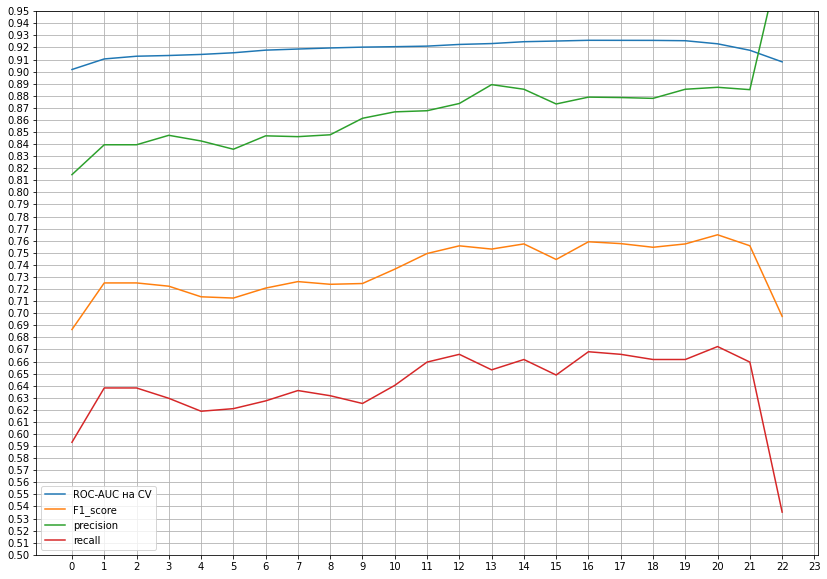

In [45]:
ax = df_score['auc_roc'].plot(
    label='ROC-AUC на CV',
    legend=True,
    figsize=(14,10),
    xticks=np.arange(0,24,1),
    yticks=np.arange(0.5, 1.01, 0.010),
    ylim=(0.5, 0.95)
)

df_score['f1_score'].plot(
    ax=ax,
    label='F1_score',
    legend=True
)

df_score['precision'].plot(
    ax=ax,
    label='precision',
    legend=True,
    grid=True
)

df_score['recall'].plot(
    ax=ax,
    label='recall',
    legend=True,
    grid=True
);

In [46]:
df_score

,del_col,auc_roc,f1_score,accuracy,precision,recall
0,TotalCharges,0.901733,0.686493,0.856086,0.814706,0.593148
1,MonthlyCharges,0.910477,0.725061,0.871445,0.839437,0.638116
2,Partner_Yes,0.912725,0.725061,0.871445,0.839437,0.638116
3,StreamingTV_Yes,0.913327,0.722359,0.871445,0.847262,0.629550
4,SeniorCitizen_Yes,0.914215,0.713580,0.868032,0.842566,0.618844
5,PaymentMethod_Electronic check,0.915584,0.712531,0.866894,0.835735,0.620985
6,PaymentMethod_Credit card (automatic),0.917761,0.720787,0.870876,0.846821,0.627409
7,MultipleLines_Yes,0.918679,0.726161,0.872582,0.846154,0.635974
8,DeviceProtection_Yes,0.919576,0.723926,0.872014,0.847701,0.631692
9,OnlineSecurity_Yes,0.920256,0.724566,0.873720,0.861357,0.625268


Судя по графику, максимальное значение ROC_AUC не является оптимальным: необходимо максимизировать и другие метрики. Таким образом, оптимальной точкой на оси Х, является 20 с ROC_AUC = 0.923. Это меньше итерации 16 с ROC_AUC = 0.925905, но, значение остальных метрик - максимально. Создадим новые выборки, с учетом столбцов, оставшихся на 20 итерации жадного алгоритма.  
Это столбцы:  
- time_use - время сотрудничества пользователя с компанией,
- InternetService_Fiber optic - пользуется ли оптикой,
- InternetService_No - пользуется ли интеренетом

`InternetService_Fiber optic` и `InternetService_No` не имеют сильную корреляцию. Оставим их на данном этапе

In [50]:
X = df_final.drop('is_left', axis=1)
y= df_final['is_left']

In [51]:
x_col = list(df_score['del_col'][:21].values)
x_col

['TotalCharges',
 'MonthlyCharges',
 'Partner_Yes',
 'StreamingTV_Yes',
 'SeniorCitizen_Yes',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Credit card (automatic)',
 'MultipleLines_Yes',
 'DeviceProtection_Yes',
 'OnlineSecurity_Yes',
 'Dependents_Yes',
 'OnlineBackup_Yes',
 'gender_Male',
 'PaperlessBilling_Yes',
 'TechSupport_Yes',
 'PaymentMethod_Mailed check',
 'StreamingMovies_Yes',
 'is_phone',
 'is_internet',
 'Type_One year',
 'Type_Two year']

In [52]:
X = X.drop(x_col, axis=1)
X

,time_use,InternetService_Fiber optic,InternetService_No
customerID,,,
7590-VHVEG,31,0,0
5575-GNVDE,1036,0,0
3668-QPYBK,61,0,0
7795-CFOCW,1371,0,0
9237-HQITU,61,1,0
...,...,...,...
6840-RESVB,730,0,0
2234-XADUH,2191,1,0
4801-JZAZL,337,0,0


In [56]:
X.corr().round(2)

,time_use,InternetService_Fiber optic,InternetService_No
time_use,1.00,0.02,-0.04
InternetService_Fiber optic,0.02,1.00,-0.47
InternetService_No,-0.04,-0.47,1.00


Подберем параметры модели на кроссвалидации. Используем выборки с полученным количеством признаков.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5274, 3) (5274,)
(1758, 3) (1758,)


```
model_cat = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    verbose=100,
    eval_metric='AUC',
    )

CV = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
params = {
    'depth': [16]
}
grid = GridSearchCV(
    model_cat,
    params,
    scoring=SCORING,
    cv=CV,
    n_jobs=-1,
    verbose=3
)
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_params_)
```

Получим значения метрик на модели с новыми параметрами

In [56]:
model_cat = CatBoostClassifier(
    max_depth=16,
    random_seed=RANDOM_STATE,
    verbose=100,
    eval_metric='AUC'
    )
model_cat.fit(X_train, y_train),


Learning rate set to 0.020955
0:	total: 5.23ms	remaining: 5.23s
100:	total: 847ms	remaining: 7.54s
200:	total: 2.87s	remaining: 11.4s
300:	total: 4.32s	remaining: 10s
400:	total: 8.16s	remaining: 12.2s
500:	total: 21.3s	remaining: 21.2s
600:	total: 1m 10s	remaining: 46.8s
700:	total: 2m 7s	remaining: 54.4s
800:	total: 3m 4s	remaining: 45.8s
900:	total: 3m 57s	remaining: 26.1s
999:	total: 4m 46s	remaining: 0us


(<catboost.core.CatBoostClassifier at 0x285fd679780>,)

In [57]:
predict_proba = model_cat.predict_proba(X_test)[:, 1]
predict = model_cat.predict(X_test)
cat_greed_roc_auc_score = roc_auc_score(y_test, predict_proba)

In [58]:
print('roc_auc_score:', cat_greed_roc_auc_score)
print('accuracy_score:', accuracy_score(y_test, predict))
print('f1_score:', f1_score(y_test, predict))
print('precision_score:', precision_score(y_test, predict))
print('recall_score:', recall_score(y_test, predict))

roc_auc_score: 0.9444739316997763
accuracy_score: 0.8998862343572241
f1_score: 0.7919621749408983
precision_score: 0.8839050131926122
recall_score: 0.7173447537473233


Построим график кривой ROC_AUC

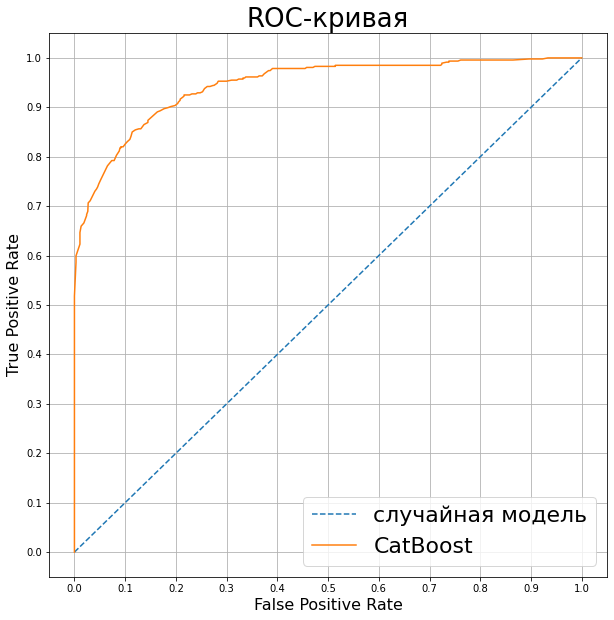

In [59]:
x=np.arange(0, 1.1, 0.1)

fpr, tpr, thresholds = roc_curve(y_test, predict_proba)


fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

ax.plot([0,1],[0,1], linestyle='--', label='случайная модель')

ax.plot(fpr, tpr, label='CatBoost')


plt.title('ROC-кривая', fontsize=26)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(x)
plt.yticks(x)
ax.legend(fontsize=22)
ax.grid(True)

plt.show()

Матрица ошибок

<AxesSubplot:>

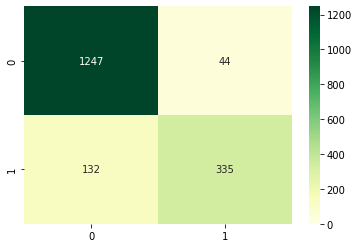

In [60]:
cat_greed_matrix = confusion_matrix(y_test, predict)

sns.heatmap(
    cat_greed_matrix,
    annot=True,
    fmt='d',
    cmap='YlGn',
    vmin=0
)

In [61]:
y_test.value_counts()

0    1291
1     467
Name: is_left, dtype: int64

### Отбор признаков по важности

Обучим модель, используя отбор признаков с помощью [sklearn.feature_selection.RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV)(рекурсивный отбор через кросс-валидацию)

In [62]:
X = df_final.drop('is_left', axis=1)
y = df_final['is_left']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5274, 24) (5274,)
(1758, 24) (1758,)


In [63]:
CV = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=RANDOM_STATE)
model_cat = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    verbose=100,
    eval_metric='AUC'
    )

```
rfecv = RFECV(
    model_cat,
    cv=CV,
    scoring=SCORING,
    verbose=3,
    n_jobs=-1,
    # importance_getter='auto'
)

rfecv.fit(X_train, y_train)

rfecv.get_support()
rfecv.cv_results_['mean_test_score']

itog = pd.DataFrame(data={
    'support':rfecv.get_support(),
    'score':rfecv.cv_results_['mean_test_score'],
    'rank':rfecv.ranking_
                   }, index=X_train.columns).sort_values(['sup', 'rank', 'score'], ascending=False)
itog
```

In [64]:
rfecv_col = [
    'time_use', 'MonthlyCharges', 'Type_Two year', 'DeviceProtection_Yes',
    'is_internet', 'PaymentMethod_Mailed check', 'is_phone',
    'Partner_Yes', 'SeniorCitizen_Yes', 'StreamingTV_Yes',
    'PaymentMethod_Credit card (automatic)', 'OnlineSecurity_Yes',
    'InternetService_No', 'OnlineBackup_Yes'
]

sup_col = [
    True, True, True, False,
    False, False, False,
    False, False, False,
    False, False, False, False
]

score_col = [
    0.904828, 0.901113, 0.894700,
    0.891569, 0.894509, 0.892756,
    0.892367, 0.892075, 0.892007,
    0.892130, 0.894302, 0.890859,
    0.891811, 0.890296
]

rank_col = [
    1, 1, 1, 22,
    21, 20, 19, 18,
    17, 16, 15, 14,
    13, 12
]

df_rfecv_cat = pd.DataFrame(
    data={
        'support': sup_col,
        'score': score_col,
        'rank': rank_col
    }, index=rfecv_col
)
df_rfecv_cat

,support,score,rank
time_use,True,0.904828,1
MonthlyCharges,True,0.901113,1
Type_Two year,True,0.894700,1
DeviceProtection_Yes,False,0.891569,22
is_internet,False,0.894509,21
PaymentMethod_Mailed check,False,0.892756,20
is_phone,False,0.892367,19
Partner_Yes,False,0.892075,18
SeniorCitizen_Yes,False,0.892007,17
StreamingTV_Yes,False,0.892130,16


Наш метод отобрал три признака:
time_use - время сотрудничества пользователя с компанией,
MonthlyCharges - месячный платёж,
Type_Two year - является ли контракт двугодичным

В целом, такой отбор укладывается в логику. Человек с двугодичным контрактом маловероятно уйдет раньше времени.

In [65]:
# создаем выборки признаков
X_train = X_train[['MonthlyCharges', 'time_use', 'Type_Two year']]
X_test = X_test[['MonthlyCharges', 'time_use', 'Type_Two year']]

```
model_cat = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    verbose=100,
    eval_metric='AUC',
    )

CV = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
params = {
    'depth': [13],
}
grid = GridSearchCV(
    model_cat,
    params,
    scoring=SCORING,
    cv=CV,
    n_jobs=-1,
    verbose=3
)
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_params_)
```

In [66]:
model_cat = CatBoostClassifier(
    depth=13,
    random_seed=RANDOM_STATE,
    verbose=100,
    eval_metric='AUC',
    )

model_cat.fit(X_train, y_train)
predict_proba = model_cat.predict_proba(X_test)[:,1]
predict = model_cat.predict(X_test)

Learning rate set to 0.020955
0:	total: 3.65ms	remaining: 3.64s
100:	total: 2.85s	remaining: 25.3s
200:	total: 5.29s	remaining: 21s
300:	total: 7.17s	remaining: 16.7s
400:	total: 9.27s	remaining: 13.8s
500:	total: 16.1s	remaining: 16s
600:	total: 24.2s	remaining: 16.1s
700:	total: 32.3s	remaining: 13.8s
800:	total: 40.6s	remaining: 10.1s
900:	total: 48.8s	remaining: 5.36s
999:	total: 1m	remaining: 0us


In [67]:
imp_roc_auc_score = roc_auc_score(y_test, predict_proba)

print('roc_auc_score:', imp_roc_auc_score)
print('accuracy_score:', accuracy_score(y_test, predict))
print('f1_score:', f1_score(y_test, predict))
print('precision_score:', precision_score(y_test, predict))
print('recall_score:', recall_score(y_test, predict))

roc_auc_score: 0.9167287281243728
accuracy_score: 0.8828213879408419
f1_score: 0.748166259168704
precision_score: 0.8717948717948718
recall_score: 0.6552462526766595


<AxesSubplot:>

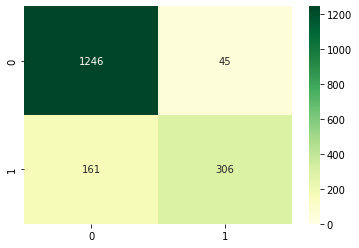

In [68]:
cat_imp_matrix = confusion_matrix(y_test, predict)
sns.heatmap(cat_imp_matrix, annot=True, cmap='YlGn', vmin=0, fmt='d')

### Отбор признаков для логистической регрессии

Рассмотрим еще одну модель для сравнения

In [69]:
X = df_final.drop('is_left', axis=1)
y = df_final['is_left']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5274, 24) (5274,)
(1758, 24) (1758,)


In [70]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rfecv = RFECV(
    model_lr,
    cv=CV,
    scoring=SCORING,
    verbose=3,
    n_jobs=-1,
)

rfecv.fit(X_train, y_train)

Fitting estimator with 24 features.


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFECV(cv=StratifiedKFold(n_splits=5, random_state=250722, shuffle=True),
      estimator=LogisticRegression(random_state=250722), n_jobs=-1,
      scoring='roc_auc', verbose=3)

In [71]:
rfecv.get_support()
rfecv.cv_results_['mean_test_score']

itog = pd.DataFrame(data={
    'sup':rfecv.get_support(),
    'score':rfecv.cv_results_['mean_test_score'],
    'rank':rfecv.ranking_
                   }, index=X_train.columns).sort_values(['sup', 'rank', 'score'], ascending=False)
itog

,sup,score,rank
StreamingMovies_Yes,True,0.844866,1
MultipleLines_Yes,True,0.843349,1
OnlineBackup_Yes,True,0.830708,1
DeviceProtection_Yes,True,0.830673,1
TechSupport_Yes,True,0.830550,1
OnlineSecurity_Yes,True,0.830499,1
StreamingTV_Yes,True,0.830422,1
InternetService_Fiber optic,True,0.829999,1
InternetService_No,True,0.829916,1
Partner_Yes,True,0.829769,1


In [72]:
X_train = X_train[rfecv.get_feature_names_out()]
X_test = X_test[rfecv.get_feature_names_out()]

In [73]:
model_lr.fit(X_train, y_train)
predict_proba = model_lr.predict_proba(X_test)[:,1]
predict = model_lr.predict(X_test)

In [74]:
imp_lr = roc_auc_score(y_test, predict_proba)

print('roc_auc_score:', imp_lr)
print('accuracy_score:', accuracy_score(y_test, predict))
print('f1_score:', f1_score(y_test, predict))
print('precision_score:', precision_score(y_test, predict))
print('recall_score:', recall_score(y_test, predict))

roc_auc_score: 0.8362431725485447
accuracy_score: 0.8026166097838453
f1_score: 0.5844311377245508
precision_score: 0.6630434782608695
recall_score: 0.5224839400428265


<AxesSubplot:>

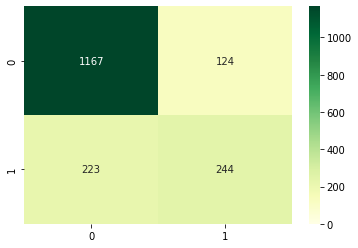

In [75]:
lr_matrix = confusion_matrix(y_test, predict)
sns.heatmap( lr_matrix, annot=True, cmap='YlGn', vmin=0, fmt='d')

### Итоги

Составим итоговые матрицы ошибок

In [87]:
pers = 100 / y_test.shape[0]

In [86]:
y_test.shape[0]

1758

In [310]:
y_test.value_counts()

0    1291
1     467
Name: is_left, dtype: int64

In [311]:
m_pers=np.array([
    [100/1291, 100/1291],
    [100/467, 100/467]
])

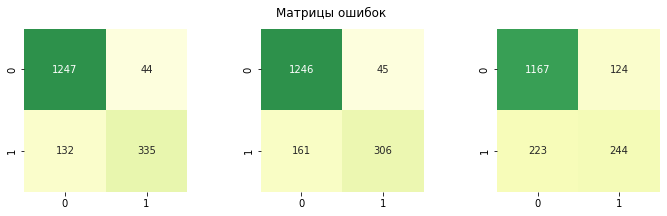

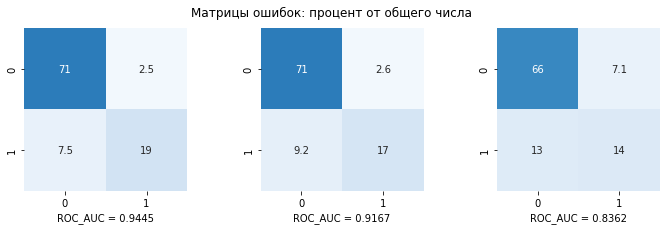

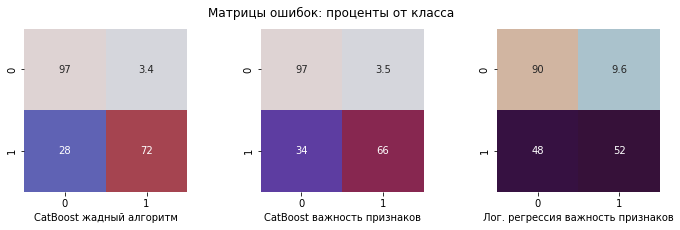

In [356]:
f_size=(12,3)

plt.figure(figsize=f_size)
plt.suptitle('Матрицы ошибок')
heat_params1 = {'annot':True, 'fmt':'d', 'cmap':'YlGn', 'vmin': 0, 'vmax': 1758, 'cbar':False, 'square':True}
sub_plot = (1,3)
# =====================================================
plt.subplot(sub_plot[0], sub_plot[1], 1)
ax = sns.heatmap( cat_greed_matrix, **heat_params1)
# ax.set_title('CatBoost жадный алгоритм')
# =====================================================
plt.subplot(sub_plot[0], sub_plot[1], 2)
ax = sns.heatmap(cat_imp_matrix, **heat_params1)
# ax.set_title('CatBoost важность признаков')
# =====================================================
plt.subplot(sub_plot[0], sub_plot[1], 3)
ax = sns.heatmap( lr_matrix, **heat_params1)
# ax.set_title('Лог. регрессия важность признаков')
# =====================================================
plt.show()
# =====================================================
# =====================================================
plt.figure(figsize=f_size)
plt.suptitle('Матрицы ошибок: процент от общего числа')
heat_params2 = {'annot':True, 'cmap':'Blues', 'vmin': 0, 'vmax':100, 'cbar':False, 'square':True}
plt.subplot(sub_plot[0], sub_plot[1], 1)
ax = sns.heatmap( cat_greed_matrix*pers, **heat_params2)
ax.set_xlabel( f"ROC_AUC = {round(cat_greed_roc_auc_score, 4)}" )
# =====================================================
plt.subplot(sub_plot[0], sub_plot[1], 2)
ax = sns.heatmap( cat_imp_matrix*pers, **heat_params2)
ax.set_xlabel( f"ROC_AUC = {round(imp_roc_auc_score, 4)}" )
# =====================================================
plt.subplot(sub_plot[0], sub_plot[1], 3)
ax = sns.heatmap( lr_matrix*pers, **heat_params2)
ax.set_xlabel( f"ROC_AUC = {round(imp_lr, 4)}" )
# =====================================================
plt.show()
# =====================================================
# =====================================================
plt.figure(figsize=f_size)
heat_params3 = {'annot':True, 'cmap':'twilight', 'vmin': 0, 'vmax':100,'cbar':False, 'square':True}
plt.suptitle('Матрицы ошибок: проценты от класса')
# =====================================================
plt.subplot(sub_plot[0], sub_plot[1], 1)
ax = sns.heatmap( cat_greed_matrix*m_pers, **heat_params3)
ax.set_xlabel('CatBoost жадный алгоритм')
# =====================================================
plt.subplot(sub_plot[0], sub_plot[1], 2)
ax = sns.heatmap(cat_imp_matrix*m_pers, **heat_params3)
ax.set_xlabel('CatBoost важность признаков')
# =====================================================
plt.subplot(sub_plot[0], sub_plot[1], 3)
ax = sns.heatmap( lr_matrix*m_pers, **heat_params3)
ax.set_xlabel('Лог. регрессия важность признаков')
# =====================================================
plt.show()

Самый выиграшный вариант - использование жадного алгоритма, с последующим анализом изменения метрик. Рассмотрим итоги обучения.  
из клиентов, которые останутся с компанией:
- правильно определит 97 %
- ошибочно 3 %

из клиентов, которые уйдут:
- правильно определит 72 % пользователей
- пропустит 28 %

Хуже показывает себя модель CatBoost, обученная на признаках, полученных с помощью отбора признаков по важности на кросс-валидации. И совсем плохо модель логистической регрессии.  
Клиентов, которые модель ошибочно определит, как ушедших, можно отнести к группе риска. Для них можно подобрать различные выгодные условия, которые мотивируют их на дальнейшее сотрудничество.

## Отчет
1. Открытие и исследование файлов.
* произведен визуальный осмотр данных,
* данные проверены на пропуски.

2. Предобработка данных.
* в таблице `контракты` удалены даты подключения и отключения, удалены пользователи, которые подключились в последнюю дату нашего датасета,
* в таблице `клиенты` значения столбца `SeniorCitizen` приведены к значениям `Yes` и `No`,

4. Анализ данных
* произведен анализ данных на которых было показано, что клиенты которые ушли, в среднем платили больше и меньше пользовались сетью интернет

5. Объединение таблиц.
* таблицы объеденены,
* пропущенные значения заменены на `No`,

6. Обучение
* в качестве борьбой с дисбалансом классов была применена техника стратифицированного семплинга,
* в качестве основной модели выбрана модель CatBoostClassifier. Для нее были применены жадный алгоритм и отбор признаков по важности через кросс-валидацию,
* Подведен итог,
* выведена матрица ошибок. даны краткие интерпритации. 